In [43]:
import os

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.utils import make_grid

%matplotlib inline
sns.set()

In [44]:
'''
This construct:
    super().__init__(self)
is valid only in Python 3.x whereas the following construct,
    super(Model, self).__init__()
works both in Python 2.x and Python 3.x.
'''

'\nThis construct:\n    super().__init__(self)\nis valid only in Python 3.x whereas the following construct,\n    super(Model, self).__init__()\nworks both in Python 2.x and Python 3.x.\n'

In [45]:
class Disricminator(nn.Module):
    def __init__(self, img_dim):
        super(Disricminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_features=img_dim, out_features=128),
            nn.LeakyReLU(negative_slope=1e-2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid(), # probability distribution of whether it is fake or real
        )
            
    def forward(self, x):
        return self.disc(x)

In [46]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_dim):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=256),
            nn.LeakyReLU(negative_slope=1e-2, inplace=True),
            nn.Linear(in_features=256, out_features=img_dim),
            nn.Tanh(), # we want the output to be from [-1, 1], as we have normalized the images
        )
        
    def forward(self, x):
        return self.gen(x)

In [47]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 128
LEARNING_RATE = 3e-4 # karpathy constant
LATENT_DIM = 128
CHANNELS = 1
HEIGHT = 28
WIDTH = 28
IMG_DIM = CHANNELS * HEIGHT * WIDTH # CHW
BATCH_SIZE = 32
WEIGHT_DECAY = 1e-4

In [48]:
disc = Disricminator(IMG_DIM).to(DEVICE)
gen = Generator(LATENT_DIM, IMG_DIM).to(DEVICE)

fixed_noise = torch.randn((BATCH_SIZE, LATENT_DIM)).to(DEVICE)

In [49]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((5e-1,), (5e-1,), inplace=True)] # img = (img - mean) / std
)

In [50]:
dataset = datasets.MNIST(root='./dataset', download=True, train=True, transform=transform)
loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), drop_last=True, shuffle=True, pin_memory=True)

In [51]:
optim_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, betas=(0.5, 0.999))
optim_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, betas=(0.5, 0.999))

# as maximizing log likelihood is the same as minimizing negative log likelihood, we can use BCELoss
criterion = nn.BCELoss() # defined as l(x, y) = L = {l_1, l_2, ..., l_n}, l_k = -w_k * (y_n * log x_n + (1 - y_n) * log(1 - x_n)); here N is the batch size

In [52]:
real_imgs = []
fake_imgs = []
for epoch in range(1, EPOCHS + 1):
    for batch_idx, (real_img, _) in enumerate(loader):
        real_img = real_img.to(DEVICE)
        real_img = real_img.view(real_img.shape[0], -1) # first is batch size
        
        noise = torch.randn(BATCH_SIZE, LATENT_DIM).to(DEVICE) # gaussian distribution with mean=0 and std=1
        fake_img = gen(noise)

        # as per the paper, k = 1, number of times the discriminator is trained before the generator
        
        # train the discriminator: max 1/n * {log(D(x)) + log(1 - D(G(z)))}, x is real and z is fake
        disc_real = disc(real_img).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real)) # y_n = 1; of BCELoss, so we get the first expression 

        # disc_fake = disc(fake_img.detach()).view(-1) # we can do fake_img.detach() or retain_graph=True, as we don't want the cache to be cleared
        disc_fake = disc(fake_img).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake)) # y_n = 0; of BCELoss, so we get the second expression
        
        lossD = (lossD_real + lossD_fake) / 2
        
        disc.zero_grad()
        lossD.backward(retain_graph=True) # we want to retain the computation graph, if we don't do this everything is cleared from the cache to save memory
        
        optim_disc.step()
        
        # train the generator: min 1/n * {log(1 - D(G(z)))}, this expression leads to saturation of gradients, weak gradients => slower learning -> max 1/n * {log(D(G(z)))}
        # here we are reusing the G(z), so we either detach the fake_img or retain the graph and not let it be cleared
        output = disc(fake_img).view(-1)
        
        lossG = criterion(output, torch.ones_like(output))
        
        gen.zero_grad()
        lossG.backward()
        
        optim_gen.step()
        
        if not batch_idx:
            print(f'Epoch: [{epoch}/{EPOCHS}] | LossD: {lossD:.4f} | LossG: {lossG:.4f}')
            with torch.inference_mode():
                fake = gen(fixed_noise).reshape(-1, CHANNELS, HEIGHT, WIDTH)
                real = real_img.reshape(-1, CHANNELS, HEIGHT, WIDTH)
                
                img_grid_fake = make_grid(fake, normalize=True)
                img_grid_real = make_grid(real, normalize=True)

                fake_imgs.append(img_grid_fake)
                real_imgs.append(img_grid_real)

Epoch: [1/128] | LossD: 0.6932 | LossG: 0.7068
Epoch: [2/128] | LossD: 0.5742 | LossG: 0.8726
Epoch: [3/128] | LossD: 0.7165 | LossG: 0.6592
Epoch: [4/128] | LossD: 0.6340 | LossG: 0.7979
Epoch: [5/128] | LossD: 0.7011 | LossG: 1.2502
Epoch: [6/128] | LossD: 0.5671 | LossG: 0.9533
Epoch: [7/128] | LossD: 0.6822 | LossG: 1.2203
Epoch: [8/128] | LossD: 0.6054 | LossG: 0.8870
Epoch: [9/128] | LossD: 0.6324 | LossG: 0.9087
Epoch: [10/128] | LossD: 0.6503 | LossG: 0.9296
Epoch: [11/128] | LossD: 0.6069 | LossG: 0.9378
Epoch: [12/128] | LossD: 0.5223 | LossG: 1.9257
Epoch: [13/128] | LossD: 0.5518 | LossG: 1.0782
Epoch: [14/128] | LossD: 0.6307 | LossG: 1.4661
Epoch: [15/128] | LossD: 0.6620 | LossG: 0.9440
Epoch: [16/128] | LossD: 0.5016 | LossG: 1.5103
Epoch: [17/128] | LossD: 0.4957 | LossG: 1.1542
Epoch: [18/128] | LossD: 0.6788 | LossG: 0.9574
Epoch: [19/128] | LossD: 0.4474 | LossG: 1.3318
Epoch: [20/128] | LossD: 0.5444 | LossG: 1.3173
Epoch: [21/128] | LossD: 0.5478 | LossG: 1.2647
E

(-0.5, 241.5, 121.5, -0.5)

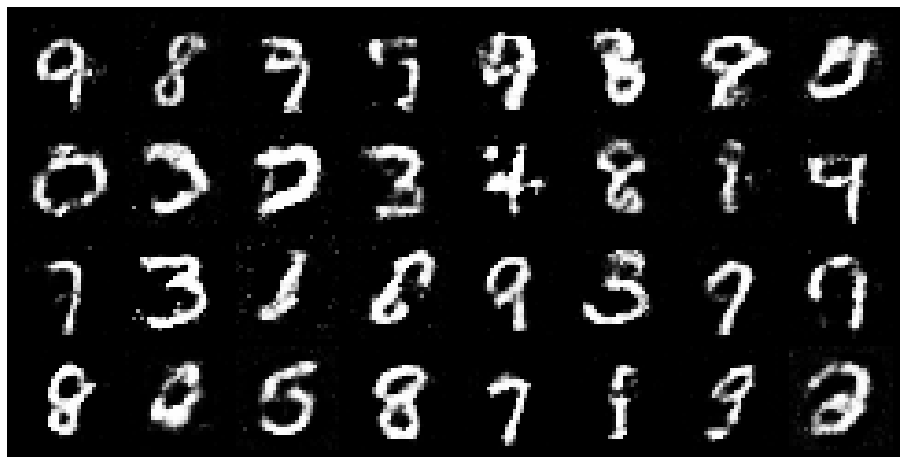

In [53]:
plt.figure(figsize=(16, 16))
plt.imshow(fake_imgs[-1].cpu().numpy().transpose((1, 2, 0)))
plt.axis('off')

(-0.5, 241.5, 121.5, -0.5)

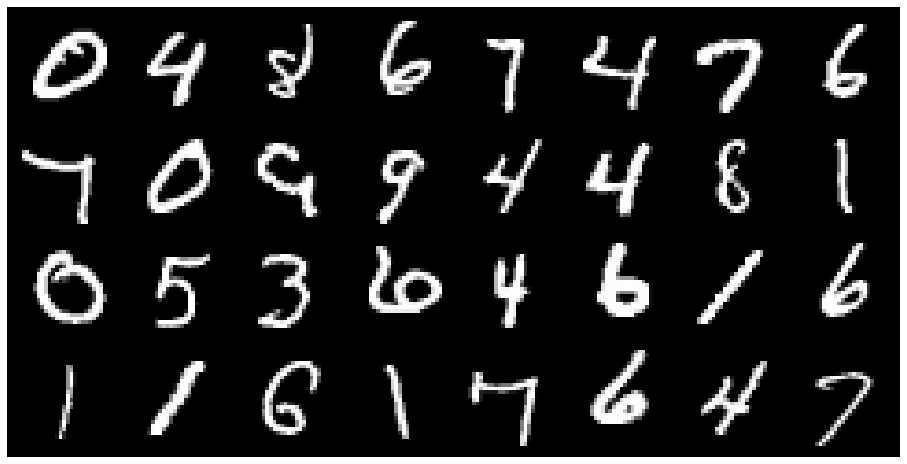

In [54]:
plt.figure(figsize=(16, 16))
plt.imshow(real_imgs[-1].cpu().numpy().transpose((1, 2, 0)))
plt.axis('off')